In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import utils
from vgg.imagenet_classes import class_names
from vgg.VGG import generate_VGG16

In [3]:
print("TensorFlow version : {}".format(tf.__version__))
print("Devices : {}".format(utils.get_tensorflow_devices()))

TensorFlow version : 1.1.0
Devices : [('/cpu:0', 'CPU'), ('/gpu:0', 'GPU')]


In [4]:
IMG_W = 224
IMG_H = 224
CHANNELS = 3

MODEL_WEIGHTS = 'vgg/vgg16.npy'

LOG_DIR = 'logs/'

STYLE_IMAGE = 'images/udnie.jpg'

In [5]:
if tf.gfile.Exists(LOG_DIR):
    tf.gfile.DeleteRecursively(LOG_DIR)
    
tf.gfile.MakeDirs(LOG_DIR)

In [6]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)

In [7]:
model, vgg_scope = generate_VGG16(weights_file=MODEL_WEIGHTS,
                                  scope="VGG16",
                                  apply_preprocess=True,
                                  remove_top=True,
                                  input_shape=(1, IMG_W, IMG_H, CHANNELS))

(1, 224, 224, 3)


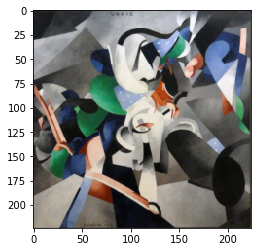

In [8]:
style_image = utils.load_image(STYLE_IMAGE,expand_dim=True)
print(style_image.shape)
plt.imshow(style_image[0])

In [9]:
mean_style_image = np.mean(style_image)
print(mean_style_image)

106.719141954


In [10]:
def style_loss(sess, model, layer):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(F, N, M):
        """
        The gram matrix G.
        """
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _loss(a, x):
        """
        The style loss calculation.
        """
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        # A is the style representation of the original image (at layer l) : numpy array
        A = _gram_matrix(a, N, M)
        # G is the style representation of the generated image (at layer l) : tensor
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return result

    loss = _loss(sess.run(model[layer]), model[layer])
    
    return loss

In [11]:
def generate_noise_image():
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(-20, 20, (1, IMG_H, IMG_W, CHANNELS)).astype('float32')
    return noise_image

(1, 224, 224, 3)


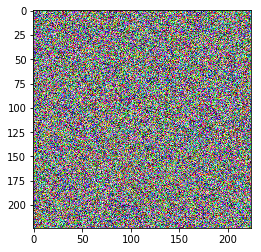

In [12]:
input_image = generate_noise_image()
print(input_image.shape)
plt.imshow(input_image[0])

## Style reconstruction from `conv1_2`

In [13]:
# Construct style_loss using content_image.
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(style_image))

with tf.name_scope("style_loss"):
    loss = style_loss(sess, model, 'conv1_2')
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(loss)

In [14]:
input_image = generate_noise_image()
sess.run(tf.global_variables_initializer())
_ = sess.run(model['input'].assign(input_image))

In [15]:
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

In [16]:
%%time

ITERATIONS = 1000

for it in range(ITERATIONS):
    _, summary = sess.run([train_step, merged])
    writer.add_summary(summary, it)
    if it%100 == 0:
        _image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(loss))
        filename = 'output/style_conv1_2_iter{}.png'.format(it)
        utils.save_image(filename, _image)
        
_image = sess.run(model['input'])
print('Iteration %d' % (it))
print('cost: ', sess.run(loss))
filename = 'output/style_conv1_2_iter{}.png'.format(it)
utils.save_image(filename, _image)


Iteration 0
cost:  1.83884e+08
Iteration 100
cost:  1.23165e+07
Iteration 200
cost:  6.74558e+06
Iteration 300
cost:  2.7354e+06
Iteration 400
cost:  847013.0
Iteration 500
cost:  354015.0
Iteration 600
cost:  205158.0
Iteration 700
cost:  138290.0
Iteration 800
cost:  99904.2
Iteration 900
cost:  75243.0
Iteration 999
cost:  58753.8
CPU times: user 7.65 s, sys: 4.65 s, total: 12.3 s
Wall time: 11.5 s


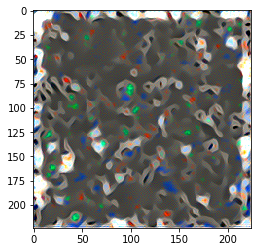

In [17]:
_image = _image[0]
_image = _image + 0.7*(mean_style_image - np.mean(_image))
_image = np.clip(_image, 0, 255).astype('uint8')
plt.imshow(_image)

In [18]:
writer.close()

## Style reconstruction from `conv2_2`

In [19]:
# Construct style_loss using content_image.
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(style_image))

with tf.name_scope("style_loss"):
    loss = style_loss(sess, model, 'conv2_2')
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(loss)
    
input_image = generate_noise_image()
sess.run(tf.global_variables_initializer())
_ = sess.run(model['input'].assign(input_image))

In [20]:
%%time

ITERATIONS = 1000

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%100 == 0:
        _image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(loss))
        filename = 'output/style_conv2_2_iter{}.png'.format(it)
        utils.save_image(filename, _image)
        
_image = sess.run(model['input'])
print('Iteration %d' % (it))
print('cost: ', sess.run(loss))
filename = 'output/style_conv2_2_iter{}.png'.format(it)
utils.save_image(filename, _image)


Iteration 0
cost:  1.53613e+09
Iteration 100
cost:  1.60663e+08
Iteration 200
cost:  5.27594e+07
Iteration 300
cost:  2.19061e+07
Iteration 400
cost:  1.11659e+07
Iteration 500
cost:  6.71724e+06
Iteration 600
cost:  4.50212e+06
Iteration 700
cost:  3.27696e+06
Iteration 800
cost:  2.52948e+06
Iteration 900
cost:  2.03171e+06
Iteration 999
cost:  1.66992e+06
CPU times: user 6.82 s, sys: 4.24 s, total: 11.1 s
Wall time: 10.8 s


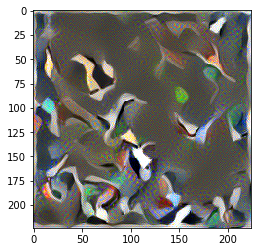

In [21]:
_image = _image[0]
_image = _image + 0.7*(mean_style_image - np.mean(_image))
_image = np.clip(_image, 0, 255).astype('uint8')
plt.imshow(_image)

## Style reconstruction from `conv3_3`

In [22]:
# Construct style_loss using content_image.
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(style_image))

with tf.name_scope("style_loss"):
    loss = style_loss(sess, model, 'conv3_3')
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(loss)
    
input_image = generate_noise_image()
sess.run(tf.global_variables_initializer())
_ = sess.run(model['input'].assign(input_image))

In [23]:
%%time

ITERATIONS = 1000

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%100 == 0:
        _image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(loss))
        filename = 'output/style_conv3_3_iter{}.png'.format(it)
        utils.save_image(filename, _image)
        
_image = sess.run(model['input'])
print('Iteration %d' % (it))
print('cost: ', sess.run(loss))
filename = 'output/style_conv3_3_iter{}.png'.format(it)
utils.save_image(filename, _image)


Iteration 0
cost:  1.60001e+09
Iteration 100
cost:  8.08024e+07
Iteration 200
cost:  4.15928e+07
Iteration 300
cost:  2.87447e+07
Iteration 400
cost:  2.24466e+07
Iteration 500
cost:  1.84782e+07
Iteration 600
cost:  1.57573e+07
Iteration 700
cost:  1.37497e+07
Iteration 800
cost:  1.22425e+07
Iteration 900
cost:  1.10568e+07
Iteration 999
cost:  1.00796e+07
CPU times: user 10.5 s, sys: 6.81 s, total: 17.3 s
Wall time: 17.1 s


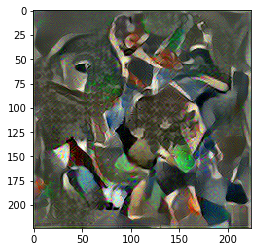

In [24]:
_image = _image[0]
_image = _image + 0.7*(mean_style_image - np.mean(_image))
_image = np.clip(_image, 0, 255).astype('uint8')
plt.imshow(_image)

## Style reconstruction from `conv4_3`

In [31]:
# Construct style_loss using content_image.
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(style_image))

with tf.name_scope("style_loss"):
    loss = style_loss(sess, model, 'conv4_3')
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(loss)
    
input_image = generate_noise_image()
sess.run(tf.global_variables_initializer())
_ = sess.run(model['input'].assign(input_image))

In [32]:
%%time

ITERATIONS = 1000

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%100 == 0:
        _image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(loss))
        filename = 'output/style_conv4_3_iter{}.png'.format(it)
        utils.save_image(filename, _image)
        
_image = sess.run(model['input'])
print('Iteration %d' % (it))
print('cost: ', sess.run(loss))
filename = 'output/style_conv4_3_iter{}.png'.format(it)
utils.save_image(filename, _image)

Iteration 0
cost:  481311.0
Iteration 100
cost:  51428.1
Iteration 200
cost:  37488.3
Iteration 300
cost:  31886.9
Iteration 400
cost:  28777.2
Iteration 500
cost:  26730.0
Iteration 600
cost:  25275.6
Iteration 700
cost:  24388.1
Iteration 800
cost:  23342.6
Iteration 900
cost:  22667.3
Iteration 999
cost:  22235.7
CPU times: user 16.9 s, sys: 10.6 s, total: 27.5 s
Wall time: 27.3 s


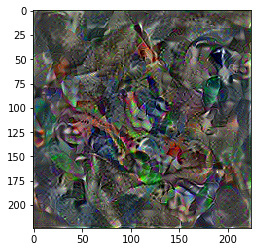

In [33]:
_image = _image[0]
_image = _image + 0.7*(mean_style_image - np.mean(_image))
_image = np.clip(_image, 0, 255).astype('uint8')
plt.imshow(_image)

## Style reconstruction from `conv5_3`

In [34]:
# Construct style_loss using content_image.
sess.run(tf.global_variables_initializer())
sess.run(model['input'].assign(style_image))

with tf.name_scope("style_loss"):
    loss = style_loss(sess, model, 'conv5_3')
    tf.summary.scalar('loss', loss)
    optimizer = tf.train.AdamOptimizer(2.0)
    train_step = optimizer.minimize(loss)
    
input_image = generate_noise_image()
sess.run(tf.global_variables_initializer())
_ = sess.run(model['input'].assign(input_image))

In [35]:
%%time

ITERATIONS = 1000

for it in range(ITERATIONS):
    sess.run(train_step)
    if it%100 == 0:
        _image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('cost: ', sess.run(loss))
        filename = 'output/style_conv5_3_iter{}.png'.format(it)
        utils.save_image(filename, _image)
        
_image = sess.run(model['input'])
print('Iteration %d' % (it))
print('cost: ', sess.run(loss))
filename = 'output/style_conv5_3_iter{}.png'.format(it)
utils.save_image(filename, _image)

Iteration 0
cost:  25.9355
Iteration 100
cost:  3.23252
Iteration 200
cost:  2.25995
Iteration 300
cost:  1.71122
Iteration 400
cost:  1.59734
Iteration 500
cost:  1.4184
Iteration 600
cost:  1.3701
Iteration 700
cost:  1.26562
Iteration 800
cost:  1.20426
Iteration 900
cost:  1.27297
Iteration 999
cost:  1.13606
CPU times: user 21 s, sys: 14.1 s, total: 35.1 s
Wall time: 34.8 s


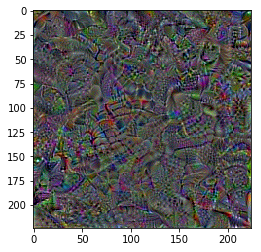

In [36]:
_image = _image[0]
_image = _image + 0.7*(mean_style_image - np.mean(_image))
_image = np.clip(_image, 0, 255).astype('uint8')
plt.imshow(_image)